In [1]:
import random 
import numpy as np
from package.Data_sim import LinearSEMSimulator
from package.PFDBNL import PF_DBN
from package.pdbn import admm_dy_personal as adp
from package.utils import opt_boundary
from package.Metric import mea_acc

import matplotlib.pyplot as plt

In [2]:
seed = 67
np.random.seed(seed)
#import the GT matrix
file_path = 'personalized_demo.npz'
matrix = np.load(file_path)
W = matrix['GT_W']
A = matrix['GT_A']

n_samples = 500
lag = 1 
K, d_vars = W.shape[0], W.shape[1]

sem_type = 'gauss'
noise_scale = 1

X_agent = np.zeros((K, n_samples, d_vars))
Y_agent = np.zeros((K, n_samples, lag * d_vars))
print(X_agent.shape, Y_agent.shape)


for k in range(K):
    simulator = LinearSEMSimulator(W[k], noise_scale)
    X = simulator.simulate(n_samples, sem_type)

    # Preprocess data for Federated Learning
    X_up = simulator.add_inter_slice_effects(X, A[k])
    Y = simulator.create_lagged_version(X, lag)

    # Add inter-slice effects and reshape
    X_agent[k] = X_up
    Y_agent[k] = Y


(3, 500, 5) (3, 500, 5)


In [3]:
print(X_agent.shape, Y_agent.shape)

(3, 500, 5) (3, 500, 5)


In [4]:
bnds = opt_boundary(X_up, Y, d_vars)

X_agent = np.array(X_agent, dtype=np.float64)
Y_agent = np.array(Y_agent, dtype=np.float64)

mu = 0.1

lambda_w = 0.1
lambda_a = 0.1
w_threshold=0.3
a_threshold=0.3

# Instantiate the solver
_, _, W_k, A_k=  PF_DBN(X_agent, Y_agent, bnds, mu = mu, lambda_w=lambda_w, lambda_a=lambda_a, partial = None, w_threshold=w_threshold, a_threshold=a_threshold)

In [5]:
shd, tpr, fdr = np.zeros(K), np.zeros(K), np.zeros(K)
shd_a, tpr_a, fdr_a = np.zeros(K), np.zeros(K), np.zeros(K)

for k in range(K):
    shd[k], fdr[k], tpr[k] = mea_acc(W_k[k],W[k])
    shd_a[k], fdr_a[k], tpr_a[k] = mea_acc(A_k[k],A[k])

print(np.mean(shd), np.mean(tpr))
print(np.mean(shd_a), np.mean(tpr_a), np.mean(fdr_a))

4.666666666666667 0.5
2.6666666666666665 0.8472222222222222 0.2638888888888889


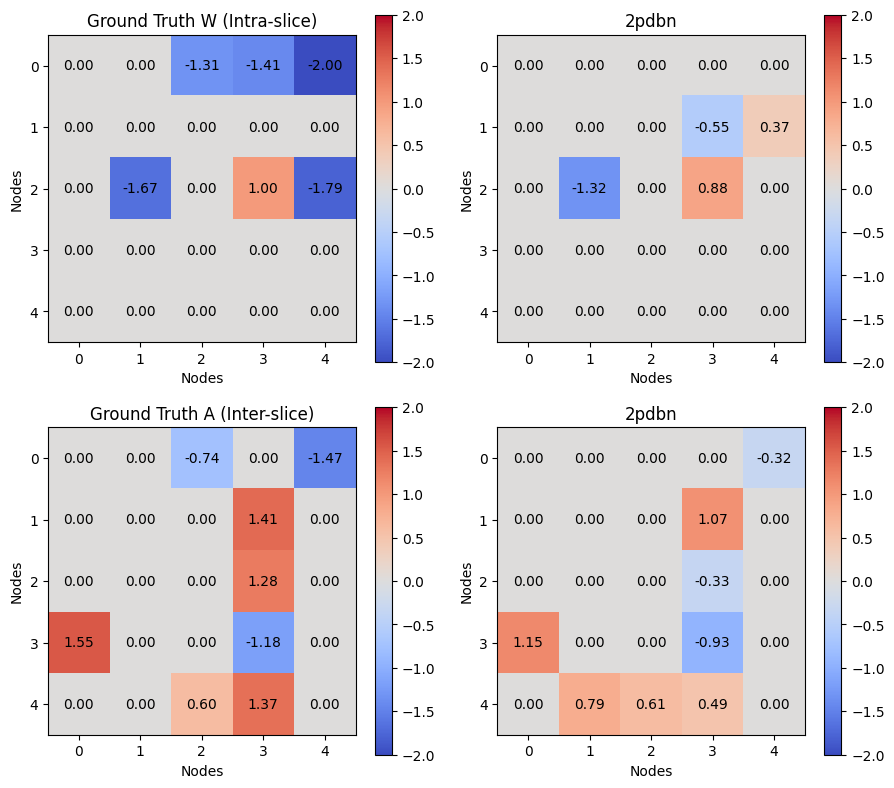

In [8]:
def p_vary(matrix, title, subplot_index):
    plt.subplot(2, 4, subplot_index)
    im = plt.imshow(matrix, cmap='coolwarm', vmin=-2, vmax=2)
    plt.colorbar(im)
    plt.title(title)
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    
    # Add text annotations inside each cell
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f"{matrix[i, j]:.2f}", ha="center", va="center", color="black")

# Set up the figure
plt.figure(figsize=(18, 8))
j = 1
# Plot ground truth matrices with annotations
p_vary(W[j], "Ground Truth W (Intra-slice)", 1)
p_vary(W_k[j], "2pdbn", 2)

# # Plot inferred matrices with annotations
p_vary(A[j], "Ground Truth A (Inter-slice)", 5)
p_vary(A_k[j], "2pdbn", 6)



# Adjust layout and show plot
plt.tight_layout()
plt.show()